<a href="https://colab.research.google.com/github/Danish-Hussain-DSAI/deepfake-image-detection-model-using-40k-images-of-bojan-dataset-available-on-kaggle/blob/main/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 !7za -y x "/content/drive/MyDrive/images.zip"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 1154340614 bytes (1101 MiB)

Extracting archive: /content/drive/MyDrive/images.zip
 10% 4096 Open              --
Path = /content/drive/MyDrive/images.zip
Type = zip
Physical Size = 1154340614

  0%      0% 378 - images/fake/06Q9Z53X3S.jpg                                       1% 598 - images/fake/0AX7T4WQ9M.jpg                                       1% 804 - images/fake/0ERS0KM2KZ.jpg                 

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D,
                          Dense, Flatten, Dropout)
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm


In [4]:
image_directory="/content/images"
dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    batch_size=8,
    image_size=(128,128),
    shuffle=True,  # Set to True if you want to shuffle the order of the images
)

Found 40272 files belonging to 2 classes.


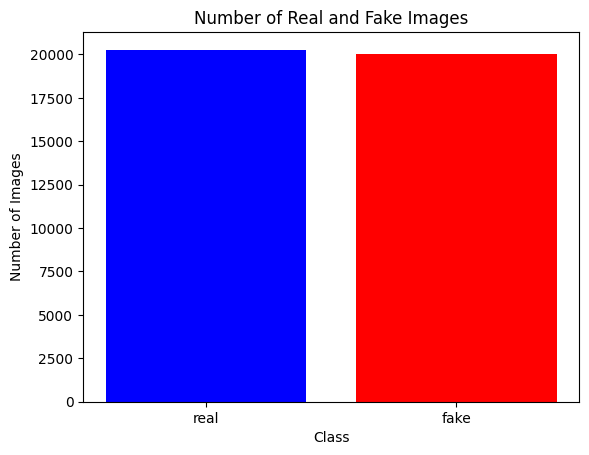

In [5]:
import os
import matplotlib.pyplot as plt

# Set the path to your dataset directory
image_directory = "/content/images"

# Get the list of class names (assuming each class is represented by a subdirectory)
class_names = os.listdir(image_directory)

# Initialize counters for each class
class_counts = {class_name: 0 for class_name in class_names}

# Count the number of images in each class
for class_name in class_names:
    class_path = os.path.join(image_directory, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot histogram
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Real and Fake Images')
plt.show()

In [6]:
classes=dataset.class_names
print(classes)

['fake', 'real']


In [7]:
from tensorflow.keras.layers import Input, Dense, Lambda

normalize = Lambda(lambda x: x / 255.0)



dataset = dataset.map(
    lambda x, y: (normalize(x), y)
)



In [9]:
# Define the size of the training set (e.g., 80% for training)
train_size = 0.8

# Calculate the number of batches for training and testing
num_batches = len(dataset)
num_train_batches = int(train_size * num_batches)
num_test_batches = num_batches - num_train_batches

# Split the dataset into training and testing sets
train_dataset = dataset.take(num_train_batches)
test_dataset = dataset.skip(num_train_batches)

# Print the sizes of the training and testing sets
print(f"Training set size: {num_train_batches} batches")
print(f"Testing set size: {num_test_batches} batches")


Training set size: 4027 batches
Testing set size: 1007 batches


In [10]:
# one-hot encoding
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

In [11]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))



# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for regularization

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for regularization

model.add(Dense(2, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                        

In [12]:
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
4027/4027 [==============================] - 146s 32ms/step - loss: 0.6287 - accuracy: 0.6654 - val_loss: 0.5215 - val_accuracy: 0.7462
Epoch 2/20
4027/4027 [==============================] - 128s 32ms/step - loss: 0.5173 - accuracy: 0.7500 - val_loss: 0.5400 - val_accuracy: 0.7289
Epoch 3/20
4027/4027 [==============================] - 125s 31ms/step - loss: 0.4660 - accuracy: 0.7833 - val_loss: 0.4695 - val_accuracy: 0.7757
Epoch 4/20
4027/4027 [==============================] - 125s 31ms/step - loss: 0.4183 - accuracy: 0.8108 - val_loss: 0.3542 - val_accuracy: 0.8508
Epoch 5/20
4027/4027 [==============================] - 123s 31ms/step - loss: 0.3846 - accuracy: 0.8320 - val_loss: 0.4592 - val_accuracy: 0.8280
Epoch 6/20
4027/4027 [==============================] - 112s 28ms/step - loss: 0.3595 - accuracy: 0.8440 - val_loss: 0.2936 - val_accuracy: 0.8803
Epoch 7/20
4027/4027 [==============================] - 123s 30ms/step - loss: 0.3394 - accuracy: 0.8539 - val_loss: 0

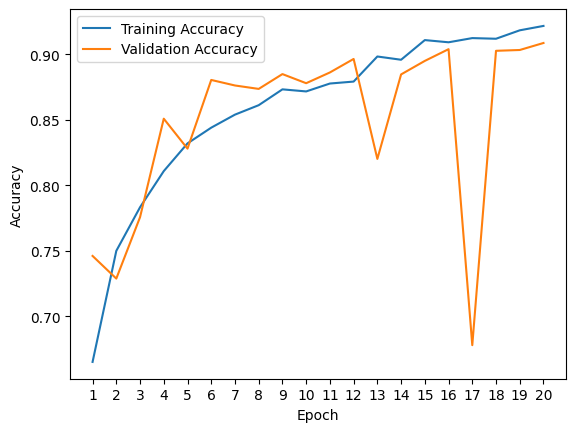

In [15]:
# Plot training and validation accuracy
epochs = range(1, 21)  # Assuming you are running for 20 epochs
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-axis ticks to the values in the epochs list
plt.legend()
plt.show()

In [16]:
model.save("deepfake_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
